# Text Classification pipeline using traditional Machine Learning methods

Authors:  
 - [Lior Gazit](https://www.linkedin.com/in/liorgazit).  
 - [Meysam Ghaffari](https://www.linkedin.com/in/meysam-ghaffari-ph-d-a2553088/).  

This notebook is taught and reviewed in our book:  
**[Mastering NLP from Foundations to LLMs](https://www.amazon.com/dp/1804619183)**  
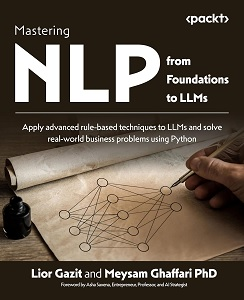

This Colab notebook is referenced in our book's Github repo:   
https://github.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs  

**Objective: Processing tweets to identify when a tweet is discussing a "company | product news".**
This notebook demonstrates a complete, end-to-end ML system design of a binary classifier.  
Given raw text of tweets, the classifier with identify which tweets are discussing a company or product news.  

## The pipeline consists of:  
1. Code settings  
1. Gathering the data  
1. Processing the data
1. Prerocessing
1. Preliminary data exploration  
1. Feature engineering  
1. Exploring the new numerical features
1. Split to Train/Test
1. Preliminary statistical analysis and feasibility study
1. Feature selection
1. Machine Learning  
 11.1 Iterate over ML models  
 11.2 Generate the chosen model  
 11.3 Generating the train results  
 11.4 Generating the test results  

*Remark:  
This is a complete ML pipeline that is designed to be fully inclusive in a single notebook file. This is meant to be an instruction tool.
In a professional dev environment, the design should be distributed across reproducible `.py` files for reproducibility and efficiency.  

## The Data:
A data set from [Hugging Face:
twitter-financial-news-topic](https://huggingface.co/datasets/zeroshot/twitter-financial-news-topic):   
>>
**"**The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their topic.  
>>
The dataset holds 21,107 documents annotated with 20 labels (note, we are re-labeling this dataset):  
topics = {    
    "LABEL_0": "Analyst Update",  
    "LABEL_1": "Fed | Central Banks",  
    "**LABEL_2": "Company | Product News"**, (note, we will focus on this label)  
    "LABEL_3": "Treasuries | Corporate Debt",  
    "LABEL_4": "Dividend",  
    "LABEL_5": "Earnings",  
    "LABEL_6": "Energy | Oil",  
    "LABEL_7": "Financials",  
    "LABEL_8": "Currencies",  
    "LABEL_9": "General News | Opinion",  
    "LABEL_10": "Gold | Metals | Materials",  
    "LABEL_11": "IPO",  
    "LABEL_12": "Legal | Regulation",  
    "LABEL_13": "M&A | Investments",  
    "LABEL_14": "Macro",  
    "LABEL_15": "Markets",  
    "LABEL_16": "Politics",  
    "LABEL_17": "Personnel Change",  
    "LABEL_18": "Stock Commentary",  
    "LABEL_19": "Stock Movement",  
}  
>>
The data was collected using the Twitter API. The current dataset supports the multi-class classification task.**"**  


**Requirements:**  
* When running in Colab, use this runtime notebook setting: `Python 3, CPU`  

>*```Disclaimer: The content and ideas presented in this notebook are solely those of the authors and do not represent the views or intellectual property of the authors' employers.```*

Install:

In [1]:
# REMARK:
# If the below code error's out due to a Python package discrepency, it may be because new versions are causing it.
# In which case, set "default_installations" to False to revert to the original image:
default_installations = True
if default_installations:
  !pip -q install datasets num2words autocorrect
else:
  import requests
  text_file_path = "requirements__Ch5_Text_Classification_Traditional_ML.txt"
  url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter5_notebooks/" + text_file_path
  res = requests.get(url)
  with open(text_file_path, "w") as f:
    f.write(res.text)

  !pip install -r requirements__Ch5_Text_Classification_Traditional_ML.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=57d747a9e1e3647fa05c653b830616c4b6d6fc3c0b2e630ac0d1c04b34a7ac16
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl s

Imports:

In [2]:
import numpy as np
import pandas as pd
import matplotlib

import scipy
import re
from datasets import load_dataset

from num2words import num2words
import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

# ML imports:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Code Settings


In [3]:
# Items:
# db_name: The db name from HuggingFace that holds the raw data
# do_preprocessing: Logical, should preprocessing be performed
# do_enhanced_preprocessing: Logical, should the computation-heavy preprocessing be performed
# do_feature_eng: Logical
# maximize_a_priori: Logocal, should the univariate preliminary feature selection be based on a priori or a postiori stats
# num_chosen_features_per_class: Int, for the preliminary feature selection, how many features should be selected per class
# test_size: ratio between 0 - 1
# feature_eng_details: Either "TfidfVectorizer" (for TFIDF feature eng.) or "CountVectorizer" (for one hot encoding)
# seed: Integer, the random seed used to insure reproducibility of results
config_dict = {'db_name': "zeroshot/twitter-financial-news-topic",
               'do_preprocessing': True,
               'do_enhanced_preprocessing': False,
               'do_feature_eng': True,
               'maximize_a_priori': True,
               'num_chosen_features_per_class': 200,
               'test_size': 0.2,
               'feature_eng_details': "CountVectorizer-binary",
               'ngram_range_min': 1,
               'ngram_range_max': 2,
               'max_features': 1000,
               'seed': 0}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


### Gathering the Data

In [4]:
dataset_raw = load_dataset(config_dict["db_name"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

### Processing the Data
Setting up the data so to include the cases we care about.  

Create one complete dataframe.  
Note that HuggingFace originally split the dataset in to two subsets, train and validation.  
We are concatenating them and later we will split them with a ratio of our choice.   

In [5]:
first_df = pd.DataFrame(dataset_raw["train"])
second_df = pd.DataFrame(dataset_raw["validation"])
dataset_df = pd.concat([first_df, second_df]).reset_index(drop=True)
dataset_df = dataset_df.rename(columns={"label": "_label_"})

Let's have a quick look at the raw data:  

In [6]:
dataset_df.head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,"Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon & more https://t.co/QPN8Gwl7Uh",0
1,"Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says https://t.co/fLS2w57iCz",0
2,"Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition https://t.co/1EmtywmYpr",0
3,"Analysts react to Tesla's latest earnings, break down what's next for electric car maker https://t.co/kwhoE6W06u",0
4,"Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside https://t.co/jPpdl0D9s4",0
5,Barclays believes earnings for these underperforming stocks may surprise Wall Street https://t.co/PHbsyVGAyE,0
6,"Bernstein upgrades Alibaba, says shares can rally more than 20% from here https://t.co/m3ApoPRGU0",0
7,"Analysts react to Netflix's strong quarter, with some pointing to a potential bottom for the stock https://t.co/cQngJsyefD",0
8,"Buy Chevron as shares look attractive at these levels, HSBC says https://t.co/GkDpFvxjEP",0
9,Morgan Stanley says these global stocks are set for earnings beats — and gives one over 45% upside https://t.co/GeWxa5YoWr,0


In [7]:
print("Distribution of original labels:\n")
dataset_df[["_label_"]].value_counts()

Distribution of original labels:



_label_
2          4397
18         2646
14         2237
9          1893
16         1234
5          1229
1          1051
19         1020
7           784
6           670
15          626
17          607
12          606
13          587
4           456
3           398
0           328
8           198
10           82
11           58
Name: count, dtype: int64

We are going to focus on one particular topic: **"Company | Product News"** (label 2)    
So we are going to re-label:  
>>
Label 0: **Not** Company | Product News  
Label 1: Company | Product News

So now the classification problem is a binary classification problem.  

In [8]:
dataset_df_binary = dataset_df.copy()
dataset_df_binary["_label_"] = dataset_df_binary["_label_"].map({2:1}).fillna(0).map(int)

In [9]:
print("Distribution of new labels:\n")
frequencies = dataset_df_binary[["_label_"]].value_counts()
frequencies

Distribution of new labels:



_label_
0          16710
1           4397
Name: count, dtype: int64

In [10]:
most_frequent_class = frequencies.index[:][0][0]
print("The most frequent class is:", most_frequent_class)
print("And its baseline probablity is:", round((dataset_df_binary["_label_"] == most_frequent_class).mean(), 3))

The most frequent class is: 0
And its baseline probablity is: 0.792


### Preporcessing


Define the preprocessing utility functions:

In [11]:
def digits_to_words(match):
  """
  Convert string digits to the English words. The function distinguishes between
  cardinal and ordinal.
  E.g. "2" becomes "two", while "2nd" becomes "second"

  Input: str
  Output: str
  """
  suffixes = ['st', 'nd', 'rd', 'th']
  # Making sure it's lower cased so not to rely on previous possible actions:
  string = match[0].lower()
  if string[-2:] in suffixes:
    type='ordinal'
    string = string[:-2]
  else:
    type='cardinal'

  return num2words(string, to=type)


def spelling_correction(text):
    """
    Replace misspelled words with the correct spelling.

    Input: str
    Output: str
    """
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)


def remove_stop_words(text):
    """
    Remove stopwords.

    Input: str
    Output: str
    """
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])


def stemming(text):
    """
    Perform stemming of each word individually.

    Input: str
    Output: str
    """
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])


def lemmatizing(text):
    """
    Perform lemmatization for each word individually.

    Input: str
    Output: str
    """
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])




def preprocessing(input_text):
  """
  This function represents a complete pipeline for text preprocessing.

  Input: str
  Output: str
  """
  output = input_text
  # Lower casing:
  output = output.lower()
  # Remove URLs:
  output = re.sub(r'http\S+', "", output)
  # Convert digits to words:
  # The following regex syntax looks for matching of consequtive digits tentatively followed by an ordinal suffix:
  output = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, output, flags=re.IGNORECASE)
  # Remove punctuations and other special characters:
  output = re.sub('[^ A-Za-z0-9]+', '', output)

  if config_dict["do_enhanced_preprocessing"]:
    # Spelling corrections:
    output = spelling_correction(output)

  # Remove stop words:
  output = remove_stop_words(output)

  if config_dict["do_enhanced_preprocessing"]:
    # Stemming:
    output = stemming(output)
    # Lemmatizing:
    output = lemmatizing(output)

  return output

Perform the preprocessing:

In [12]:
dataset_clean = dataset_df_binary.copy()
if config_dict["do_preprocessing"]:
  dataset_clean["text"] = [preprocessing(text) for text in dataset_clean["text"]]

In [13]:
dataset_clean.head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,thursdays biggest analyst calls apple amazon tesla palantir docusign exxon amp,0
1,buy las vegas sands travel singapore builds wells fargo says,0
2,piper sandler downgrades docusign sell citing elevated risks amid ceo transition,0
3,analysts react teslas latest earnings break whats next electric car maker,0
4,netflix peers set return growth analysts say giving one stock one hundred twenty upside,0
5,barclays believes earnings underperforming stocks may surprise wall street,0
6,bernstein upgrades alibaba says shares rally twenty,0
7,analysts react netflixs strong quarter pointing potential bottom stock,0
8,buy chevron shares look attractive levels hsbc says,0
9,morgan stanley says global stocks set earnings beats gives one fortyfive upside,0


## Preliminary data exploration
Every ML project should start with basic exploration of the data.  
The objectives are mainly to explore the nature of the data, and to study whether there is a connection between the "X" data (in our case, tweets' text) and the desired value, "Y" (in our case, classifying the topic).  

Here we start by looking at the most simple characteristic of the data: the length of each tweet.  
We will later explore the statistical dependence between the language used and the topic label.  

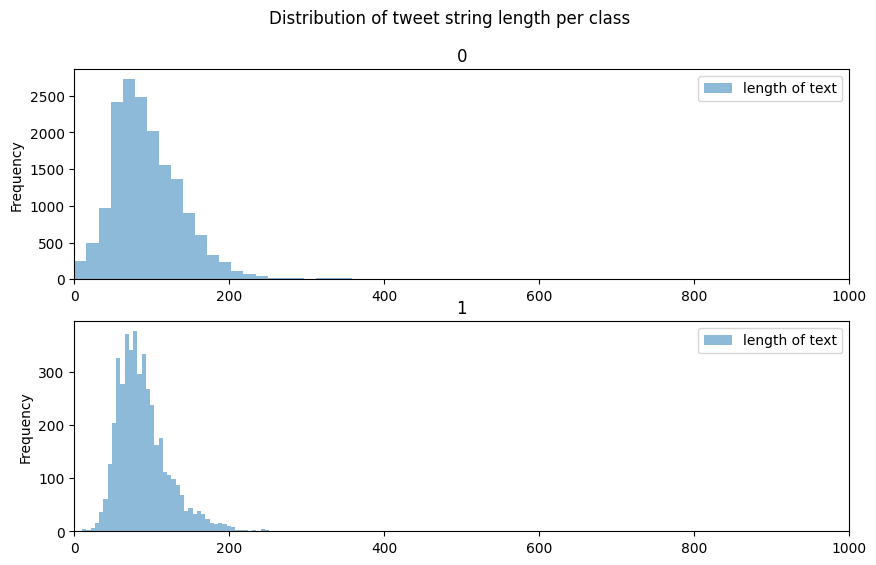

In [14]:
dataset_clean["length of text"] = dataset_clean["text"].map(len)
ax = dataset_clean.plot.hist(column=["length of text"], by="_label_", bins=50, alpha=0.5, figsize=(10, 6), title="Distribution of tweet string length per class", xlim=[0, 1000])

## Feature engineering

In [15]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
  if "CountVectorizer-binary" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Binary (one hot encoding)")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=True)

  elif "CountVectorizer-BOW" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Bag of words")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=False)

  out_arr = countvectorizer.fit_transform(in_df[text_col])
  count_tokens = countvectorizer.get_feature_names_out()
  out_df = pd.DataFrame(data = out_arr.toarray(),columns = count_tokens)
  out_df[labels_col] = list(in_df[labels_col])
  return out_df


if config_dict["do_feature_eng"]:
  dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', '_label_', config_dict)
else:
  # This option isn't being supported, the notebook would fail. This option is
  # here to cater for a ML pipeline that uses deep learning language models that consume text, and not engineered features.
  dataset_feat_eng = dataset_clean.copy()

Feature Engineering method: Binary (one hot encoding)


## Exploring the new numerical features  

In [16]:
dataset_feat_eng.head()

,aapl,ab,access,according,acquire,acquires,acquisition,action,activity,actual,...,yy,zeroeight,zerofive,zerofour,zeroone,zeroseven,zerosix,zerothree,zerotwo,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
dataset_feat_eng.describe().loc[['min', 'max', 'mean']]

,aapl,ab,access,according,acquire,acquires,acquisition,action,activity,actual,...,yy,zeroeight,zerofive,zerofour,zeroone,zeroseven,zerosix,zerothree,zerotwo,_label_
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
mean,0.00379,0.002653,0.003459,0.016582,0.003316,0.004074,0.007344,0.007154,0.002701,0.003459,...,0.003316,0.002511,0.00379,0.004785,0.004501,0.003459,0.002653,0.003411,0.004548,0.20832


## Split to Train/Test

In [18]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index)

## Preliminary statistical analysis and feasibility study
This process is perhaps the most valuable for the preliminary study prior to applying ML.  
This is where we measure the relationship between "X" and "Y" so to see whether there is a "correlation".  

If this were a regression problem, where X and Y are numerical, then it would make sense to evaluate the correlation between X and Y, so to learn whether one could expect a linear regression model to yield good results.

Since neither X nor Y are numerical in their nature, we seek to evaluated the **statistical dependence** between them, so to know whether a model would have any "signal" to pick up on.  

Calc:  
**P(feature | class)**

In [19]:
## Statistics of features per class:
means_by_class = dataset_feat_eng_train.groupby(by=["_label_"]).mean().T.sort_index()
means_by_class.head()

_label_,0,1
aapl,0.004269,0.002830
ab,0.003146,0.000000
access,0.002397,0.007357
according,0.019847,0.004527
acquire,0.004269,0.000000


Calc the ratio that reflects statistical dependence:  
**P(class, feature)/(P(class)P(feature))**  
And note that it could be rewritten as:  
**P(class | feature)/P(class)**  
Or equivalently:  
**P(feature | class)/P(feature)**  

\*Note:  
The below calculation is assuming that the numerical features of each text term is **binary**, only then is the below a probability measure.  
If another feature method is used, such as BoW or TF/IDF, then the below is not the probability, but a proxy of it.  

In [20]:
P_class = sorted([[c, np.mean(dataset_feat_eng["_label_"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "_label_"])
P_feature_inv = [[f, 1/p] for f, p in P_feature]

P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
# Multiplying a "column vector" of feature probablities with a "line vector" of
# class probilities to get a matrix where each element is a product of probabilities:
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))

P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    # Right hand side: P(feature | class) / P(feature)
    P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)




**The terms that are most indicative of class "0":**

In [21]:
P_class_given_feature.sort_values([0], ascending=False)[[0]].head(10)

_label_,0
latest updates,1.411439
gasoline,1.402971
spx esf,1.398410
encourages investors,1.393258
warning,1.390024
upside,1.380427
monthly distribution,1.375892
contact firm,1.373492
esf,1.373492
ago,1.372025


**The terms that are most indicative of class "1":**

In [22]:
P_class_given_feature.sort_values([1], ascending=False)[[1]].head(10)

_label_,1
launches,4.718646
solution,4.386093
partnership,4.316795
announcement form,4.221977
form eightthree,4.221977
uk regulatory,4.121902
regulatory announcement,4.121902
plc,4.063799
partner,4.029674
cloud,3.981702


## Feature selection
This is a univariate feature selection process.  
It is based on conditional dependence between a feature being 0/1 and a class being 0/1, thus the mean value of the feature is its probability.  
Note that the process of feature selection is done **on the training set**.   


For each class, choose the most indicative features.  
Either maximize the:   
* a-priori distribution P(feature | class), Max Liklihood  
or  
* a posteriori P(class | feature), MAP

In [23]:
chosen_features = []
if config_dict["maximize_a_priori"] == True:
  classes = means_by_class.columns
  for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])
else:
  classes = P_class_given_feature.columns
  for c in classes:
    chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])


chosen_features = list(set(chosen_features))

In [24]:
chosen_features

['european',
 'musk',
 'day',
 'technology',
 'model',
 'qtwo thousand',
 'according',
 'quarterly',
 'stockmarket',
 'fda',
 'cloud',
 'dividend',
 'health',
 'watch',
 'twentytwo earnings',
 'airlines',
 'government',
 'says',
 'earnings',
 'plans',
 'eps',
 'worlds',
 'europe',
 'ahead',
 'operations',
 'president',
 'netflix',
 'china',
 'month',
 'buy',
 'low',
 'solution',
 'annual',
 'qqq',
 'elon musk',
 'fix',
 'russian',
 'technologies',
 'billion',
 'tesla',
 'tsla',
 'futures',
 'solutions',
 'rise',
 'million',
 'increase',
 'signs',
 'future',
 'shares',
 'said',
 'report',
 'second',
 'major',
 'including',
 'release',
 'seven',
 'fed',
 'development',
 'customer',
 'product',
 'financial results',
 'portfolio',
 'fast',
 'finance',
 'treatment',
 'people',
 'quarter thousand',
 'recession',
 'new',
 'thousand',
 'named',
 'services',
 'years',
 'best',
 'platform',
 'series',
 'energy',
 'support',
 'conference',
 'companies',
 'management',
 'action',
 'investor',
 'ju

### Leave only chosen features:
Now that we deduced which features are "important" based on the train set, we select them for both the train set and the test set.  

In [25]:
dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ["_label_"])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ["_label_"])

dataset_feat_eng_train_selected.head()

,european,musk,day,technology,model,qtwo thousand,according,quarterly,stockmarket,fda,...,beats,apple,demand,vehicle,set,center,risk,high,credit,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
dataset_feat_eng_train_selected["_label_"].value_counts()

_label_
0    13352
1     3534
Name: count, dtype: int64

# Machine Learning   


In [27]:
dataset_feat_eng_train_selected.head()

,european,musk,day,technology,model,qtwo thousand,according,quarterly,stockmarket,fda,...,beats,apple,demand,vehicle,set,center,risk,high,credit,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Parse out the Y labels from the dataset, and change the variable type to suit the models.

In [28]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]

x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]

#### Iterate over ML models

In [29]:
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=config_dict['seed'])))
models.append(("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=config_dict['seed'])))
models.append(("SVM", SVC(gamma='auto', random_state=config_dict['seed'])))

results = []
names = []
best_mean_result = 0
best_std_result = 0
for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, x_features_train, y_labels_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(round(np.std(cv_results), 3)))
  if (best_mean_result < np.mean(cv_results)) or \
    ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
    best_mean_result = np.mean(cv_results)
    best_std_result = np.std(cv_results)
    best_model_name = name
    best_model = model
print("\nBest model is:\n" + best_model_name)

Random Forest: mean(accuracy)=0.837, std(accuracy)=0.033
LASSO: mean(accuracy)=0.847, std(accuracy)=0.02
KNN: mean(accuracy)=0.81, std(accuracy)=0.038
Decision Tree: mean(accuracy)=0.817, std(accuracy)=0.029
SVM: mean(accuracy)=0.796, std(accuracy)=0.005

Best model is:
LASSO


Observe the distribution of the results across the validation folds:

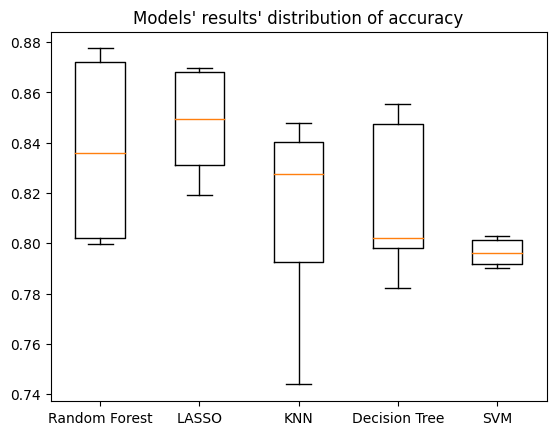

In [30]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Models' results' distribution of accuracy")
matplotlib.pyplot.show()

### Generate the chosen model

Optimize the hyperparameters:

In [31]:
model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)
print("The optimal hyperparameter 'C' is:", grid_search.best_params_["C"])

The optimal hyperparameter 'C' is: 1.0535263157894736


Fit the optimized model to the training set:

In [32]:
model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=config_dict['seed'])
model.fit(x_features_train, y_labels_train)

LogisticRegression(C=1.0535263157894736, max_iter=1000, random_state=0)

In [33]:
# These two cells are for if we wanted to pick the Random Forest model:

# model = RandomForestClassifier()
# params = {"n_estimators": range(10, 31, 3),
#           "min_samples_split": range(2, 10, 2)}
# grid_search = GridSearchCV(model, params)
# grid_search.fit(x_features_train, y_labels_train)

# print("The optimal hyperparameter 'n_estimators' is:", grid_search.best_params_["n_estimators"])
# print("The optimal hyperparameter 'min_samples_split' is:", grid_search.best_params_["min_samples_split"])


In [34]:
# model = RandomForestClassifier(n_estimators=grid_search.best_params_["n_estimators"],
#                                min_samples_split=grid_search.best_params_["min_samples_split"],
#                                )
# model.fit(x_features_train, y_labels_train)

### Generate the train results: Use for Design Choices

In [35]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)

print("Results on the train set:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_train, 2))
print("Current model's accuracy:", round(accuracy_train, 2))
print("The accuracy lift is:", round(accuracy_lift_train), "%")

Results on the train set:
-------------------------
Baseline (dummy classifier) accuracy: 0.79
Current model's accuracy: 0.88
The accuracy lift is: 11 %


### Generate the test results: Use for presenting performance

In [37]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)

print("Results on the test set:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_test, 2))
print("Current model's accuracy:", round(accuracy_test, 2))
print("The accuracy lift is:", round(accuracy_lift), "%")


print("\nConfusion Matrix:")
print(confusion_matrix(y_labels_test, y_test_estimated))
print("\nClassification Report:")
print(classification_report(y_labels_test, y_test_estimated))

Results on the test set:
-------------------------
Baseline (dummy classifier) accuracy: 0.8
Current model's accuracy: 0.87
The accuracy lift is: 10 %

Confusion Matrix:
[[3230  128]
 [ 408  455]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3358
           1       0.78      0.53      0.63       863

    accuracy                           0.87      4221
   macro avg       0.83      0.74      0.78      4221
weighted avg       0.87      0.87      0.86      4221

